In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from scipy import stats
from sklearn import metrics
import statsmodels.formula.api as smf
import warnings
pd.options.display.max_columns = None
plt.style.use("dark_background")
warnings.filterwarnings("ignore")

In [31]:
#limpieza zipcodes con muestra menor a 120 casas
casas = pd.read_csv("/Users/fernandoseguias/Desktop/ferseg/Proyectos/Programacion/iron_hack/ironhack_labs/linear_regression_washington/casas_limpio.csv", index_col=0)
casas['zipcode'] = casas['zipcode'].astype(str)

drop_zipcode = casas['zipcode'].value_counts() <= 120
drop_zipcode = drop_zipcode.loc[drop_zipcode == True].index
casas_limpio = casas.drop(index=casas.loc[casas['zipcode'].isin(drop_zipcode)].index)
print(f'shape casas: {casas.shape}')
print(f'shape casas_limpio: {casas_limpio.shape}')
print(f'{casas.shape[0] - casas_limpio.shape[0]} casas eliminadas por muestra inferior a 55 por zipcode')
print(f'zipcodes eliminados: {drop_zipcode}')
df = casas_limpio.copy()
df.describe(include='all').T

shape casas: (21562, 13)
shape casas_limpio: (20947, 13)
615 casas eliminadas por muestra inferior a 55 por zipcode
zipcodes eliminados: Index(['98070', '98109', '98102', '98010', '98024', '98148', '98039'], dtype='object')


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
bedrooms,20947.0,NaN,NaN,NaN,3.377333,0.901995,1.0,3.0,3.0,4.0,11.0
bathrooms,20947.0,NaN,NaN,NaN,2.057956,0.746603,1.0,2.0,2.0,2.0,8.0
floors,20947.0,NaN,NaN,NaN,1.532534,0.553996,1.0,1.0,2.0,2.0,4.0
waterfront,20947.0,NaN,NaN,NaN,0.006493,0.080316,0.0,0.0,0.0,0.0,1.0
view,20947.0,NaN,NaN,NaN,0.22915,0.757662,0.0,0.0,0.0,0.0,4.0
condition,20947.0,NaN,NaN,NaN,3.411897,0.643966,2.0,3.0,3.0,4.0,5.0
grade,20947.0,NaN,NaN,NaN,7.655941,1.162763,3.0,7.0,7.0,8.0,13.0
sqft_above,20947.0,NaN,NaN,NaN,1785.592734,819.058674,370.0,1190.0,1560.0,2210.0,9410.0
sqft_basement,20947.0,NaN,NaN,NaN,292.240082,441.580476,0.0,0.0,0.0,570.0,4130.0
zipcode,20947,63,98103,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN


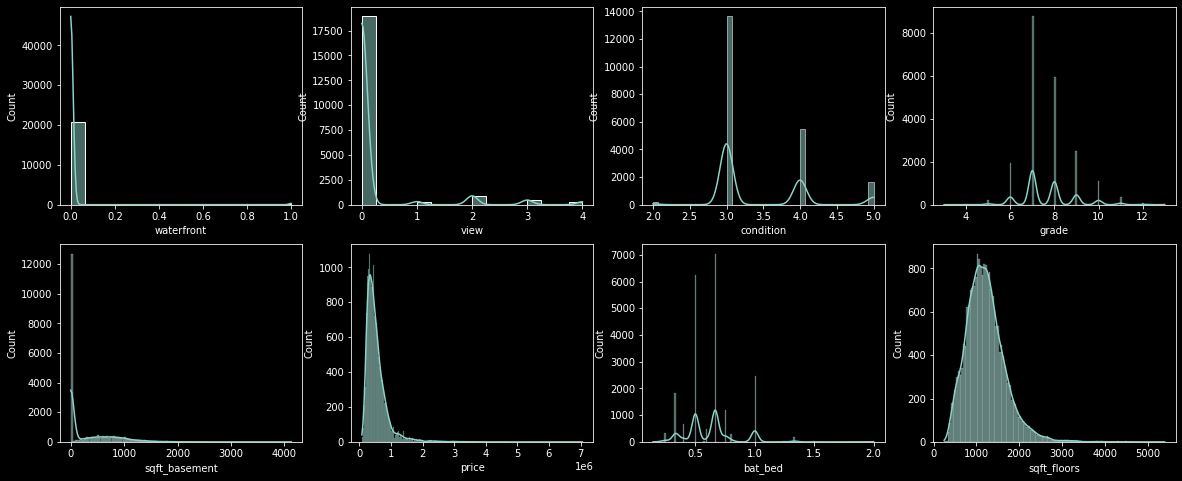

In [32]:
#distribucion inicial todas las variables numericas
columnas = ['waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'price', 'bat_bed', 'sqft_floors']
df_num = df[columnas]
fig, ax = plt.subplots(2,4, figsize = (20,8))
ax = ax.flat
for i in range(len(columnas)):
    sns.histplot(df_num[columnas[i]], kde = True, ax = ax[i])
plt.show();

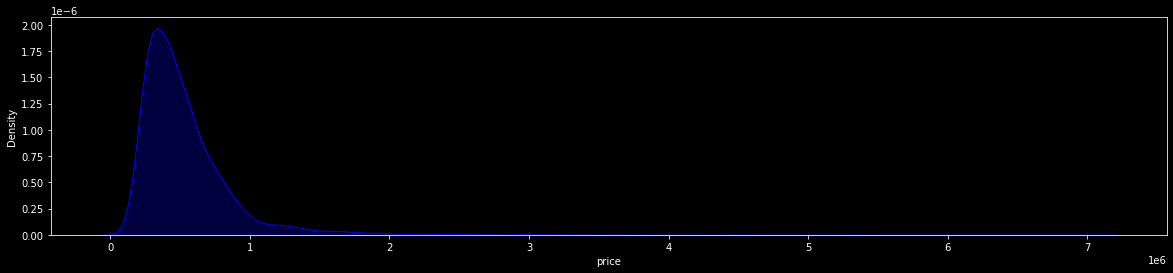

In [33]:
#distribucion inicial variable respuesta price
fig, axes = plt.subplots(figsize = (20, 4))
sns.distplot(
    df.price, 
    hist = False, 
    color = "blue", 
    kde_kws = {"shade": True, "linewidth": 1});

condition y price no tienen correlacion


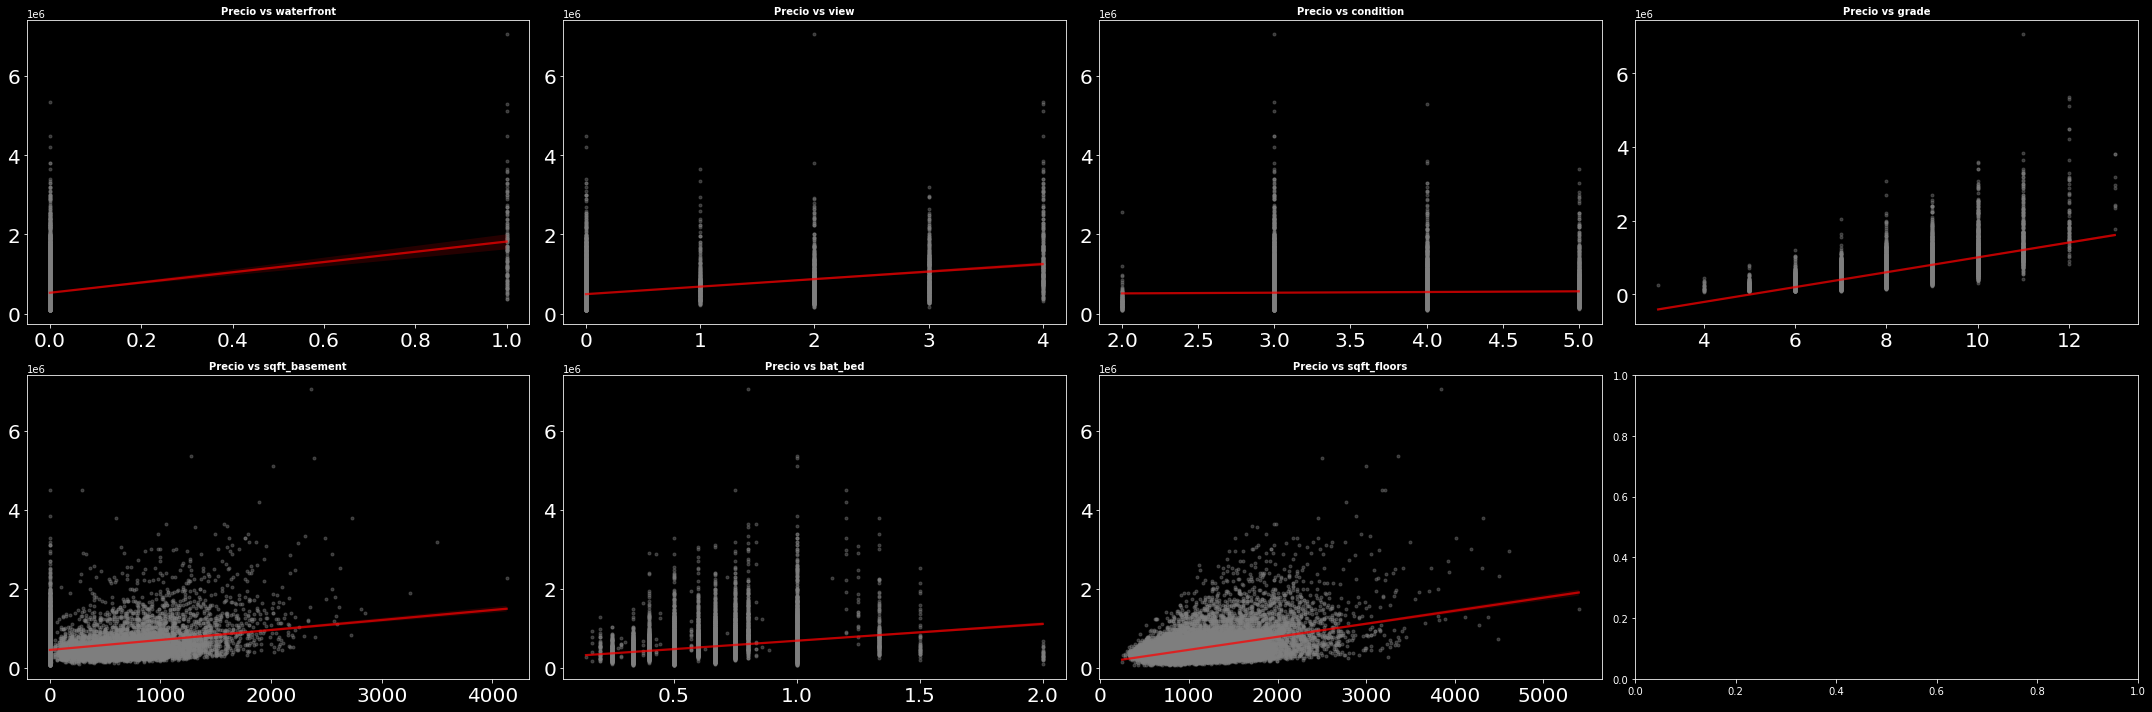

In [34]:
#plotteamos correlaciones entre variables predictoras y respuesta
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (30, 10))

axes = axes.flat

num_col = df_num.columns
num_col = num_col.drop("price")

for i, colum in enumerate(num_col):
    sns.regplot(
        x = df[colum], 
        y = df["price"], 
        color = "gray", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4}, 
        line_kws = {"color": "red", "alpha": 0.7 }, 
        ax = axes[i])
    
    axes[i].set_title(f"Precio vs {colum}", fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    
fig.tight_layout();
print('condition y price no tienen correlacion')

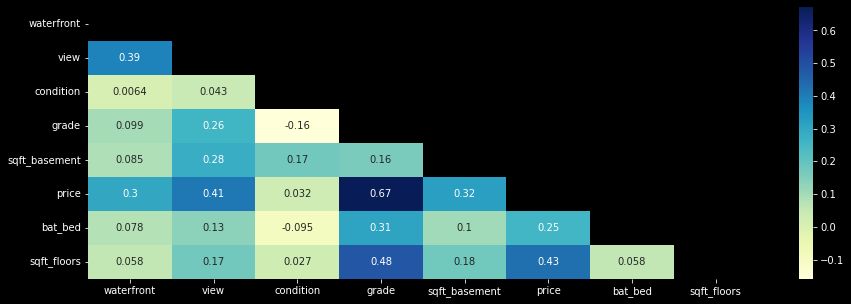

In [35]:
#heatmap de correlaciones
fig, axes = plt.subplots(figsize = (15, 5))
mask = np.triu(np.ones_like(df_num.corr(), dtype = np.bool))
sns.heatmap(df_num.corr(), 
           cmap = "YlGnBu", 
            mask = mask,
           annot = True);

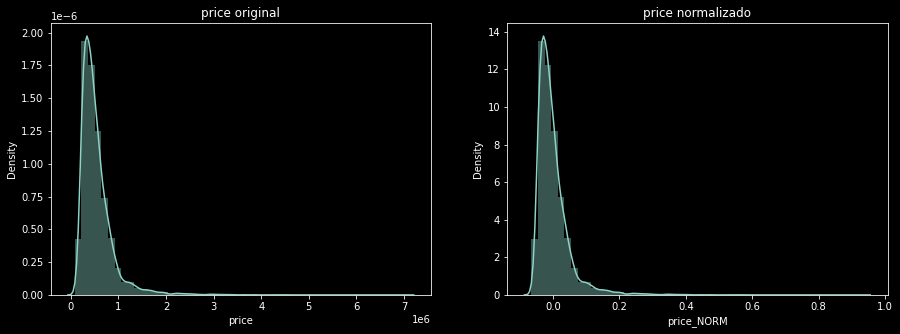

In [36]:
#intento de normalizacion manual
media = df["price"].mean()
maximo = df["price"].max() 
minimo = df["price"].min()
df["price_NORM"] = (df["price"] - media) / (maximo - minimo )
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('price original')
axes[1].set_title('price normalizado')

sns.distplot(df['price'] ,ax = axes[0])
sns.distplot(df['price_NORM'], ax = axes[1]);

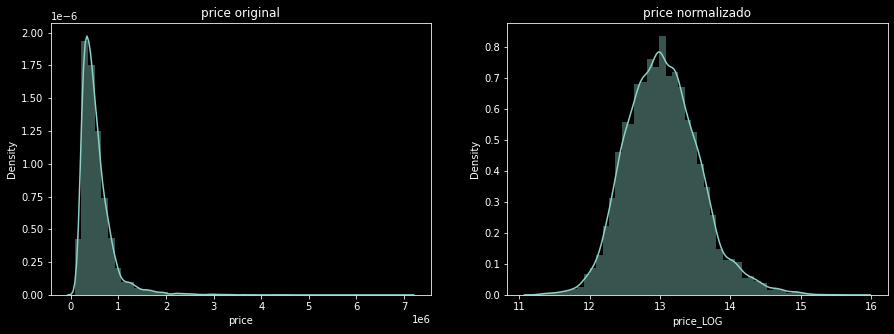

In [37]:
#intento de normalizar log
df['price_LOG'] = df['price'].apply(lambda x: np.log(x) if x != 0 else 0)
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('price original')
axes[1].set_title('price normalizado')

sns.distplot(df['price'] ,ax = axes[0])
sns.distplot(df['price_LOG'], ax = axes[1]);

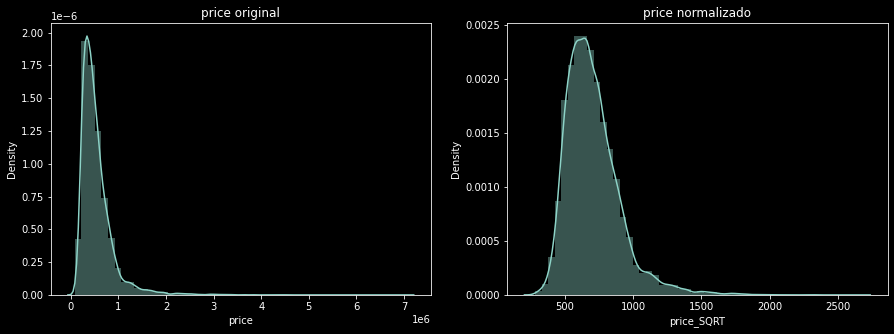

In [38]:
#intento de normalizar raiz cuadrada
df['price_SQRT'] = df['price'].apply(lambda x: math.sqrt(x))
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('price original')
axes[1].set_title('price normalizado')

sns.distplot(df['price'] ,ax = axes[0])
sns.distplot(df['price_SQRT'], ax = axes[1]);

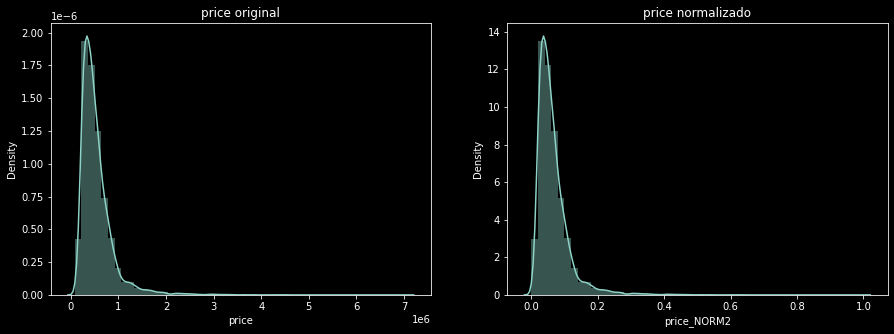

In [39]:
#intento de normalizar sklearn minmaxscaller
minmax = MinMaxScaler()
minmax.fit(df[["price"]])
X_normalizadas = minmax.transform(df[["price"]])
df["price_NORM2"] = X_normalizadas
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('price original')
axes[1].set_title('price normalizado')

sns.distplot(df['price'] ,ax = axes[0])
sns.distplot(df['price_NORM2'], ax = axes[1]);

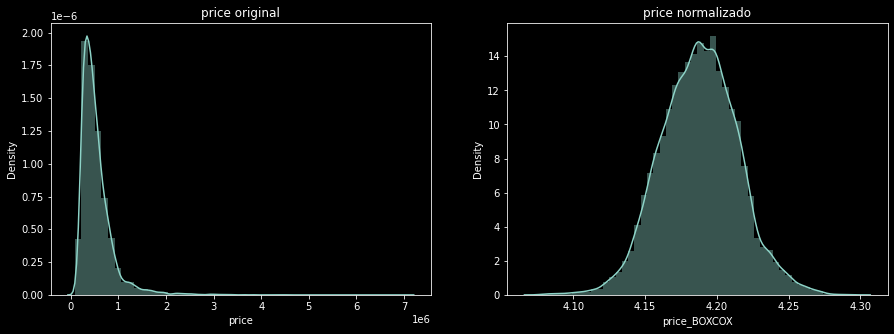

In [40]:
#normalizacion boxcox
fitted_data, fitted_lambda = stats.boxcox(df['price'])
df['price_BOXCOX'] = fitted_data
df['price_BOXCOX']

fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('price original')
axes[1].set_title('price normalizado')

sns.distplot(df['price'] ,ax = axes[0])
sns.distplot(df['price_BOXCOX'], ax = axes[1]);

In [41]:
#estandarizacion robustscaler
robust = RobustScaler()

columnas_robust = ["sqft_above", "bedrooms", "bathrooms", "floors", "waterfront", "view", "condition", "grade", "sqft_basement", "price_BOXCOX", "bat_bed", "sqft_floors"]
columnas_robust_modif = ["sqft_above_est", "bedrooms_est", "bathrooms_est", "floors_est", "waterfront_est", "view_est", "condition_est", "grade_est", "sqft_basement_est", "price_BOXCOX_est", "bat_bed_est", "sqft_floors_est"]

robust.fit(df[columnas_robust])
X_robust = robust.transform(df[columnas_robust])
df[columnas_robust_modif] = X_robust

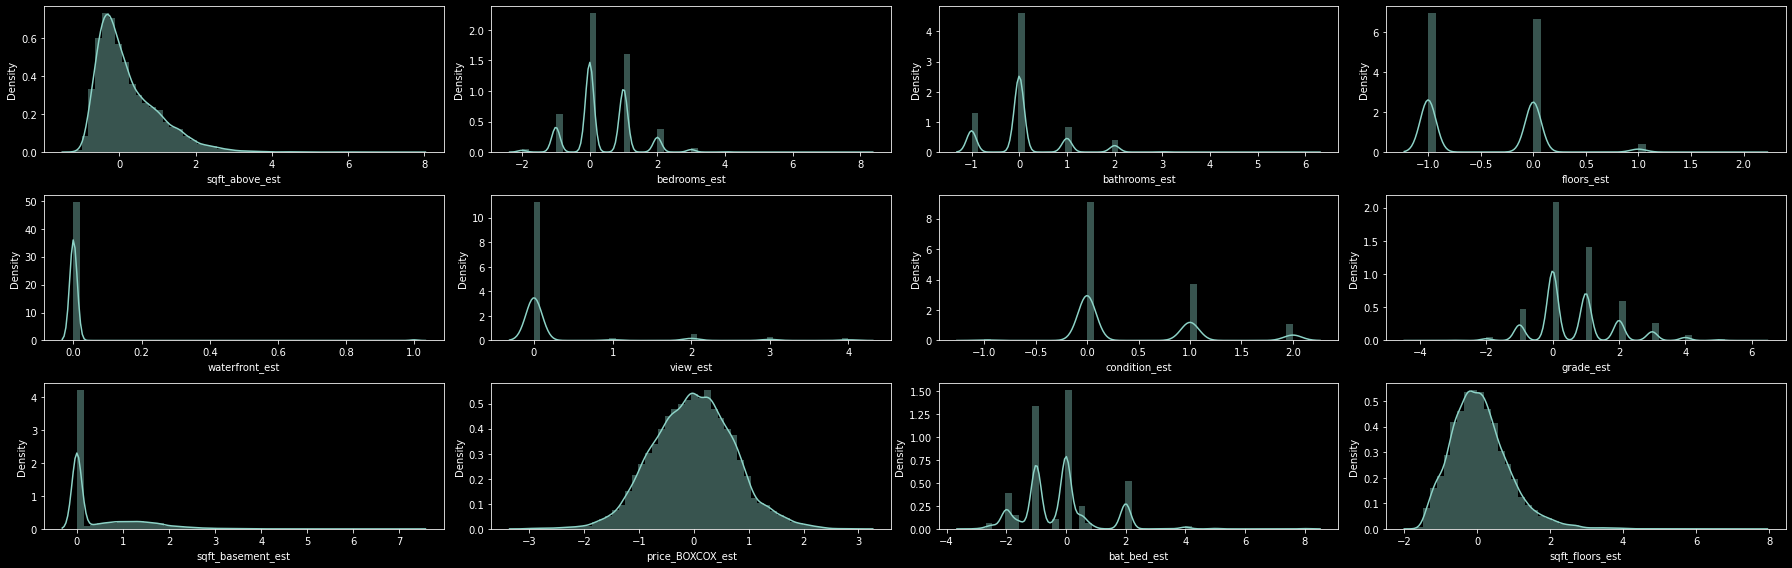

In [42]:
#ploteamos distribuciones de las variables estandarizadas
fig, axes = plt.subplots(3, 4, figsize = (25,8))

axes = axes.flat
contador = 0

for i in columnas_robust_modif:
    sns.distplot(df[i] ,ax = axes[contador]);
    contador += 1
plt.tight_layout()
plt.show();

In [43]:
#filtramos las variables a utilizar
variables_ml = ['price_BOXCOX', 'sqft_above_est', 'sqft_floors_est', 'bathrooms_est', 'grade_est', 'sqft_basement_est', 'waterfront_est', 'view_est', 'zipcode']
df = df[variables_ml]
df

,price_BOXCOX,sqft_above_est,sqft_floors_est,bathrooms_est,grade_est,sqft_basement_est,waterfront_est,view_est,zipcode
0,4.147752,-0.372549,0.018018,-1.0,0.0,0.000000,0.0,0.0,98178
1,4.197314,0.598039,-0.153153,0.0,0.0,0.701754,0.0,0.0,98125
2,4.134518,-0.774510,-0.720721,-1.0,-1.0,0.000000,0.0,0.0,98028
3,4.203087,-0.500000,-0.216216,1.0,0.0,1.596491,0.0,0.0,98136
4,4.194596,0.117647,0.918919,0.0,1.0,0.000000,0.0,0.0,98074
...,...,...,...,...,...,...,...,...,...
21592,4.176057,-0.029412,-1.189189,0.0,1.0,0.000000,0.0,0.0,98103
21593,4.181820,0.735294,-0.027027,0.0,1.0,0.000000,0.0,0.0,98146
21594,4.182103,-0.529412,-1.189189,-1.0,0.0,0.000000,0.0,0.0,98144
21595,4.181820,0.039216,-0.666667,0.0,1.0,0.000000,0.0,0.0,98027


In [44]:
#resultados usando libreria stats
results = smf.ols("price_BOXCOX ~  sqft_above_est + sqft_floors_est + bathrooms_est + grade_est + sqft_basement_est + waterfront_est + view_est + zipcode", data=df).fit() 
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           price_BOXCOX   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     1658.
Date:                Sat, 14 May 2022   Prob (F-statistic):               0.00
Time:                        00:50:38   Log-Likelihood:                 65599.
No. Observations:               20947   AIC:                        -1.311e+05
Df Residuals:                   20877   BIC:                        -1.305e+05
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.1527      0.001   7421.853      0.000       4.152       4.154
zipcode[T.98002]     -0.0027      0.001     -2.907      0.004      -0.005      -0.001
zipcode[T.98003]      0.0009      0.001      1.097      0.273      -0.001       0.003
zipcode[T.98004]      0.0560      0.001     68.043      0.000       0.054       0.058
zipcode[T.98005]      0.0415      0.001     41.649      0.000       0.040       0.043
zipcode[T.98006]      0.0354      0.001     47.718      0.000       0.034       0.037
zipcode[T.98007]      0.0369      0.001     35.048      0.000       0.035       0.039
zipcode[T.98008]      0.0361      0.001     42.835      0.000       0.034       0.038
zipcode[T.98011]      0.0265      0.001     28.094      0.000       0.025       0.028
zipcode[T.98014]      0.0185      0.001     16.834      0.000       0.016       0.021
zipcode[T.98019]      0.0201      0.001     21.160      0.000       0.018       0.022
zipcode[T.98022]      0.0057      0.001      6.407      0.000       0.004       0.007
zipcode[T.98023]     -0.0014      0.001     -1.883      0.060      -0.003    5.65e-05
zipcode[T.98027]      0.0297      0.001     38.774      0.000       0.028       0.031
zipcode[T.98028]      0.0245      0.001     29.060      0.000       0.023       0.026
zipcode[T.98029]      0.0333      0.001     40.754      0.000       0.032       0.035
zipcode[T.98030]      0.0037      0.001      4.256      0.000       0.002       0.005
zipcode[T.98031]      0.0054      0.001      6.392      0.000       0.004       0.007
zipcode[T.98032]     -0.0024      0.001     -2.186      0.029      -0.005      -0.000
zipcode[T.98033]      0.0420      0.001     55.518      0.000       0.041       0.044
zipcode[T.98034]      0.0299      0.001     41.597      0.000       0.028       0.031
zipcode[T.98038]      0.0113      0.001     15.954      0.000       0.010       0.013
zipcode[T.98040]      0.0464      0.001     54.367      0.000       0.045       0.048
zipcode[T.98042]      0.0048      0.001      6.623      0.000       0.003       0.006
zipcode[T.98045]      0.0193      0.001     21.282      0.000       0.017       0.021
zipcode[T.98052]      0.0359      0.001     50.208      0.000       0.034       0.037
zipcode[T.98053]      0.0326      0.001     42.228      0.000       0.031       0.034
zipcode[T.98055]      0.0074      0.001      8.724      0.000       0.006       0.009
zipcode[T.98056]      0.0184      0.001     24.097      0.000       0.017       0.020
zipcode[T.98058]      0.0105      0.001     14.118      0.000       0.009       0.012
zipcode[T.98059]      0.0205      0.001     27.604      0.000       0.019       0.022
zipcode[T.98065]      0.0237      0.001     28.676      0.000       0.022       0.025
zipcode[T.98072]      0.0292      0.001     34.272      0.000       0.027

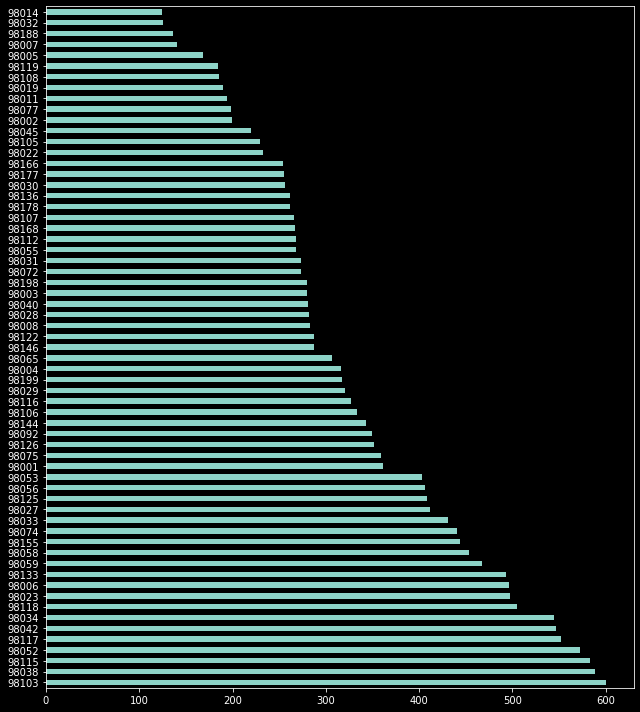

,price_BOXCOX,sqft_above_est,sqft_floors_est,bathrooms_est,grade_est,sqft_basement_est,waterfront_est,view_est,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
21132,4.250727,2.323529,1.432432,3.0,3.0,0.982456,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3973,4.205537,-0.215686,-0.900901,0.0,0.0,0.000000,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
#variable categorica zipcode encoding
dummies = pd.get_dummies(df["zipcode"], prefix_sep = "_", prefix = "zipcode", dtype = int)
df[dummies.columns] = dummies
fig, axes = plt.subplots(figsize = (9,10))

df['zipcode'].value_counts().plot.barh()
    
fig.tight_layout()
plt.show();
df.drop(["zipcode"], axis = 1, inplace = True)
df.sample(2)

In [46]:
#reparto de datos en train y test
X = df.drop(["price_BOXCOX"], axis = 1)
y = df['price_BOXCOX']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size   = 0.8, random_state = 42)

print("Datos de entrenamiento")
print("-----------------------")
print(y_train.describe())
print('\n')
print("Datos de testeo")
print("-----------------------")
print(y_test.describe())

Datos de entrenamiento
-----------------------
count    16757.000000
mean         4.187755
std          0.026937
min          4.076888
25%          4.169449
50%          4.188101
75%          4.205911
max          4.295941
Name: price_BOXCOX, dtype: float64


Datos de testeo
-----------------------
count    4190.000000
mean        4.188243
std         0.026657
min         4.085081
25%         4.169975
50%         4.188195
75%         4.205747
max         4.287860
Name: price_BOXCOX, dtype: float64


In [47]:
#variables predictoras
X.sample(5)

,sqft_above_est,sqft_floors_est,bathrooms_est,grade_est,sqft_basement_est,waterfront_est,view_est,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
11528,2.421569,0.312312,2.0,2.0,0.000000,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
13611,-0.254902,0.234234,0.0,1.0,0.000000,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13580,0.392157,1.423423,0.0,2.0,3.087719,0.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
13915,0.186275,-0.531532,1.0,1.0,0.000000,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19624,0.368627,1.380180,0.0,1.0,0.000000,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [48]:
#variable respuesta
pd.Series(y).sample(5)

3290     4.156718
16063    4.193581
4520     4.220592
13627    4.155496
2323     4.159603
Name: price_BOXCOX, dtype: float64

In [49]:
#sklearn linear regression results
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_test = lr.predict(X_test)
y_pred_train = lr.predict(X_train)
train_df = pd.DataFrame({'Real': y_train, 'Predicted': y_pred_train, 'Set': ['Train']*len(y_train)})
test_df  = pd.DataFrame({'Real': y_test,  'Predicted': y_pred_test,  'Set': ['Test']*len(y_test)})
results = pd.concat([train_df,test_df], axis = 0)
results['residual'] = results['Real'] - results['Predicted']
results['residual_porcentual'] = (results['Real'] - results['Predicted']) / results['Real'] * 100
results['residual_porcentual_abs'] = results['residual_porcentual'].abs()
results.head(10).sort_values(by = 'residual_porcentual_abs', ascending = False)

,Real,Predicted,Set,residual,residual_porcentual,residual_porcentual_abs
18911,4.205919,4.218794,Train,-0.012875,-0.306122,0.306122
1420,4.216436,4.205849,Train,0.010587,0.251091,0.251091
9336,4.169003,4.177038,Train,-0.008035,-0.192721,0.192721
8415,4.169449,4.175861,Train,-0.006411,-0.153772,0.153772
7032,4.207917,4.202752,Train,0.005165,0.122751,0.122751
16262,4.165754,4.170309,Train,-0.004555,-0.109352,0.109352
19148,4.186188,4.190624,Train,-0.004435,-0.105954,0.105954
19020,4.194796,4.192791,Train,0.002005,0.047791,0.047791
1171,4.175903,4.173930,Train,0.001972,0.047233,0.047233
444,4.142816,4.141737,Train,0.001079,0.026039,0.026039


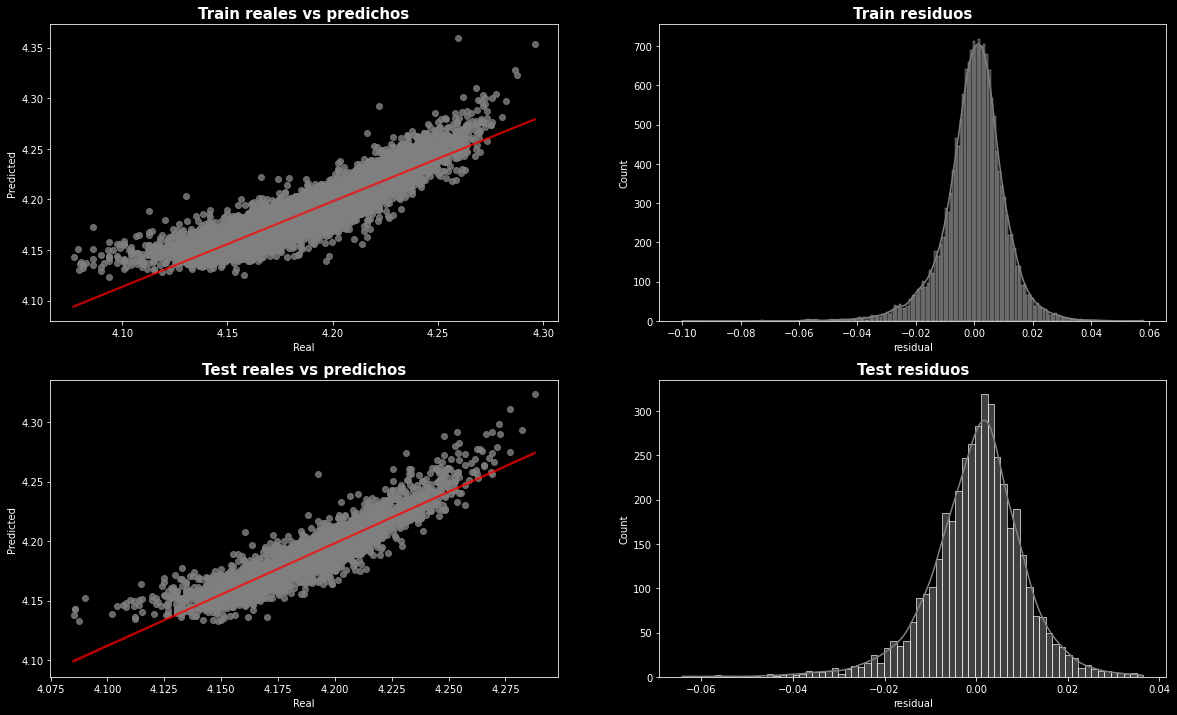

In [50]:
#plotteamos train y test (reales vs predichos) + residuos
fig, ax = plt.subplots(2,2,figsize=(20,12))

# ploteamos los reales vs los predichos
sns.regplot(data = results[results['Set'] == "Train"], 
            x = "Real", 
            y = "Predicted", 
            ax = ax[0,0], 
            color = "grey",
            line_kws = {"color": "red", "alpha": 0.7 })


sns.regplot(data = results[results['Set'] == "Test"], 
            x = "Real",
            y = "Predicted", 
            color = "gray",
            line_kws = {"color": "red", "alpha": 0.7 }, 
            ax = ax[1,0])


# ploteamos los residuos
sns.histplot(results[results['Set'] == "Train"],
             x="residual",
             color ="grey",
             kde=True, 
             ax = ax[0,1])


sns.histplot(results[results['Set'] == "Test"],
             x="residual",
             color = "grey",
             kde=True, 
             ax = ax[1,1])

ax[0,0].set_title("Train reales vs predichos", fontsize = 15, fontweight = "bold")
ax[0,1].set_title("Train residuos", fontsize = 15, fontweight = "bold")
ax[1,0].set_title("Test reales vs predichos", fontsize = 15, fontweight = "bold")
ax[1,1].set_title("Test residuos", fontsize = 15, fontweight = "bold");

In [51]:
#predicciones y metricas sklearn metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_test))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
print("R2:",  metrics.r2_score(y_test, y_pred_test))
print('\n')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_pred_train))
print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_pred_train))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
print("R2:",  metrics.r2_score(y_train, y_pred_train))

def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    resultados = {'MAE': [metrics.mean_absolute_error(y_test, y_test_pred), metrics.mean_absolute_error(y_train, y_train_pred)],
                'MSE': [metrics.mean_squared_error(y_test, y_test_pred), metrics.mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))],
                'R2':  [metrics.r2_score(y_test, y_test_pred), metrics.r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

lr_results = metricas(y_test, y_train, y_pred_test, y_pred_train, "Regresion lineal")
range_var_predict = df['price_BOXCOX'].max() - df['price_BOXCOX'].min()
lr_results['var_perc_rmse_var_predict'] = [lr_results['RMSE'][0]/range_var_predict, lr_results['RMSE'][1]/range_var_predict]
lr_results['RMSE_avg_price_calc'] = casas_limpio['price'].mean() * lr_results['var_perc_rmse_var_predict']
lr_results.style.background_gradient(cmap='coolwarm')

Mean Absolute Error: 0.007627836961308736
Mean Squared Error: 0.00010781854463140777
Root Mean Squared Error: 0.010383570899811286
R2: 0.8482297404828966


Mean Absolute Error: 0.007652396396672792
Mean Squared Error: 0.00011260241942887575
Root Mean Squared Error: 0.010611428717608
R2: 0.8448065601007301


,MAE,MSE,RMSE,R2,set,modelo,var_perc_rmse_var_predict,RMSE_avg_price_calc
0,0.007628,0.000108,0.010384,0.848230,test,Regresion lineal,0.047402,25328.898269
1,0.007652,0.000113,0.010611,0.844807,train,Regresion lineal,0.048442,25884.717413


In [52]:
#analizamos la variable respuesta (normalizada con boxcox - precios no reales)
max = df['price_BOXCOX'].max()
min = df['price_BOXCOX'].min()
mean = df['price_BOXCOX'].mean()
print(f'max:{max}')
print(f'min:{min}')
print(f'avg:{mean}')
print(f'diferencia:{max-min}')

max:4.2959413065791
min:4.076887704899687
avg:4.1878527404056225
diferencia:0.21905360167941268


In [53]:
#creamos dataframe comparativo precios reales y precios boxcox, ademas aplicamos funcion inverse_boxcox y obtenemos delta
price_comp = {'real_price' : casas_limpio['price'], 'price_BOXCOX' : df['price_BOXCOX']}
price_comp = pd.DataFrame(price_comp)

def invboxcox(y,ld):
   if ld == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(ld*y+1)/ld))

price_comp['apply_inv_boxcox'] = (invboxcox(price_comp['price_BOXCOX'], fitted_lambda))
price_comp['difference'] = (price_comp['apply_inv_boxcox'] - price_comp['real_price']).astype(int)
price_comp

,real_price,price_BOXCOX,apply_inv_boxcox,difference
0,221900,4.147752,221900.0,0
1,538000,4.197314,538000.0,0
2,180000,4.134518,180000.0,0
3,604000,4.203087,604000.0,0
4,510000,4.194596,510000.0,0
...,...,...,...,...
21592,360000,4.176057,360000.0,0
21593,400000,4.181820,400000.0,0
21594,402101,4.182103,402101.0,0
21595,400000,4.181820,400000.0,0


In [54]:
#probamos la funcion con el primer precio boxcox
invboxcox(4.147752, fitted_lambda)

221898.9833953617

In [55]:
#importancia de las variables predictoras
regressor = DecisionTreeRegressor(random_state = 0) 
regressor.fit(X_train, y_train)
max_features = np.sqrt(len(X_train.columns))
max_features
print(regressor.tree_.max_depth)
y_pred_test_dt = regressor.predict(X_test)
y_pred_train_dt = regressor.predict(X_train)

importancia_predictores = pd.DataFrame(
                            {'predictor': X_train.columns,
                             'importancia': regressor.feature_importances_}
                            )

importancia_predictores.sort_values( ascending=False, by= "importancia", inplace=True)
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.head(10)

81
Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
3,grade_est,0.475655
0,sqft_above_est,0.079301
4,sqft_basement_est,0.051460
1,sqft_floors_est,0.043574
6,view_est,0.027231
19,zipcode_98023,0.023959
10,zipcode_98004,0.017874
7,zipcode_98001,0.013525
30,zipcode_98042,0.012776
43,zipcode_98092,0.012755
